In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Test Multiclass Classification Problem - Python API

Load data...
Start training...
[1]	valid_0's multi_logloss: 1.60151
[2]	valid_0's multi_logloss: 1.59502
[3]	valid_0's multi_logloss: 1.58942


/Users/haoychen/anaconda/lib/python2.7/site-packages/lightgbm-0.1-py2.7.egg/lightgbm/engine.py:161: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  booster.add_valid(valid_set, name_valid_set)


[4]	valid_0's multi_logloss: 1.58483
[5]	valid_0's multi_logloss: 1.58056
[6]	valid_0's multi_logloss: 1.57338
[7]	valid_0's multi_logloss: 1.56937
[8]	valid_0's multi_logloss: 1.56464
[9]	valid_0's multi_logloss: 1.56184
[10]	valid_0's multi_logloss: 1.557
Finish first 10 rounds...


save the model

Load the model and continue training

[11]	valid_0's multi_logloss: 1.55199
[12]	valid_0's multi_logloss: 1.54744
[13]	valid_0's multi_logloss: 1.54383
[14]	valid_0's multi_logloss: 1.53917
[15]	valid_0's multi_logloss: 1.53559
[16]	valid_0's multi_logloss: 1.53159
[17]	valid_0's multi_logloss: 1.52805
[18]	valid_0's multi_logloss: 1.52438
[19]	valid_0's multi_logloss: 1.52042
[20]	valid_0's multi_logloss: 1.51696
Finish 10 - 20 rounds with model file...


[21]	valid_0's multi_logloss: 1.51332
[22]	valid_0's multi_logloss: 1.5092
[23]	valid_0's multi_logloss: 1.50587
[24]	valid_0's multi_logloss: 1.50285
[25]	valid_0's multi_logloss: 1.49995
[26]	valid_0's multi_logloss: 1.49655
[27]	valid

/Users/haoychen/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  exec(code_obj, self.user_global_ns, self.user_ns)


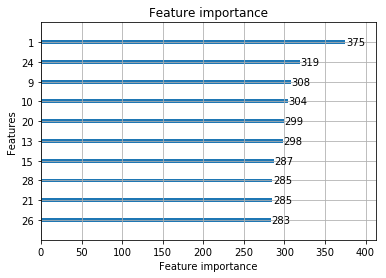





Plot 84th tree...


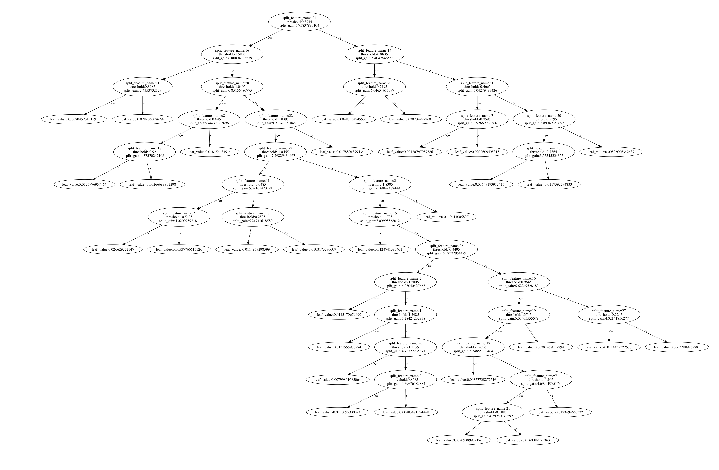

In [2]:
# load dataset
print "Load data..."

df_train = pd.read_csv('data/multiclass.train', header=None, sep='\t')
df_test = pd.read_csv('data/multiclass.test', header=None, sep='\t')

# Specify features and labels in train and test data
y_train = df_train[0]
y_test = df_test[0]
X_train = df_train.drop(0, axis=1)
X_test = df_test.drop(0, axis=1)

num_train, num_features = X_train.shape

# Create dataset for lightGBM
# set free_raw_data=Flase if we want to re-use raw data
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, free_raw_data=False)

# specify configurations as a dict
params = {
    'boosting_type': 'gbdt',         # Traditional Gradient Boosting
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 5,
    'metric_freq': 1,                
    'is_training_metric': True,
    'max_bin': 255,                  # Specify the max #bin for each feature
    'num_leaves': 31,                # In leaf-wise algorithm, set #leaves to control complexity; 
                                     # In level-wise algorithm, set #depth. The relation is #leaves = 2 ^ (#depth)
    'learning_rate': 0.05,
    'num_trees': 100,                
    'early_stopping': 10,
    'verbose': 0
}


# generate a feature name
feature_name = ['feature_' + str(col) for col in range(num_features)]

print 'Start training...'
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_test,
                feature_name=feature_name)

# check feature name
print 'Finish first 10 rounds...\n\n'



# save model to file
print "save the model\n"
gbm.save_model('model/model_10.txt')     # save the Booster as a txt file

# continue training
# init_model accepts:
# 1. model file name
# 2. Booster()

print "Load the model and continue training\n"
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model='model/model_10.txt',
                valid_sets=lgb_test)

print 'Finish 10 - 20 rounds with model file...\n\n'

# decay learning rates
# learning_rates accepts:
# 1. list/tuple with length = num_boost_round
# 2. function(curr_iter)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=lgb_test)

print 'Finish 20 - 30 rounds with decay learning rates...\n\n'

# change other parameters during training
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_test,
                callbacks=[lgb.reset_parameter(bagging_fraction=[0.7] * 5 + [0.6] * 5)])

print 'Finish 30 - 40 rounds with changing bagging_fraction...\n\n'


# reset metric
# specify configurations as a dict
params = {
    'boosting_type': 'gbdt',         # Traditional Gradient Boosting
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': 5,
    'metric_freq': 1,                
    'is_training_metric': True,
    'max_bin': 255,                  # Specify the max #bin for each feature
    'num_leaves': 31,                # In leaf-wise algorithm, set #leaves to control complexity; 
                                     # In level-wise algorithm, set #depth. The relation is #leaves = 2 ^ (#depth)
    'learning_rate': 0.05,
    'num_trees': 100,                
    'early_stopping': 10,
    'verbose': 0
}

# lightGBM allow users to specify their own loss function and evaluate metrics
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_test)
print 'Finish 40 - 50 rounds with changing evaluation metric...\n\n'


print "Print the predicted values of test data"
gbm.predict(X_test[:10])

print "\n\n\n"
print "plot feature importance"
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

print "\n\n\n"
print "Plot 84th tree..."
ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [3]:
# will not change the model gbm
print "cross-validation with given parameters"
lgb.cv(params,
       lgb_train,
       num_boost_round=10,
       init_model=gbm)

cross-validation with given parameters


{u'multi_error-mean': [0.21685714285714286,
  0.22057142857142856,
  0.22542857142857145,
  0.23000000000000004,
  0.23285714285714282,
  0.23857142857142857,
  0.24271428571428572,
  0.24499999999999997,
  0.24828571428571428,
  0.25157142857142861],
 u'multi_error-stdv': [0.013221812528190385,
  0.015775206586829307,
  0.014523731459587236,
  0.014033487645991785,
  0.011175775551775973,
  0.010747567356459454,
  0.0099836601198035231,
  0.009835379701747719,
  0.0093197179601714787,
  0.010472510176063573]}

#### Test Multiclass Classification Problem - Python sklearn API

In [4]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [5]:
print('Start training...')
# train
gbm = lgb.LGBMClassifier(boosting_type="dart",
                         objective='multiclass',
                         num_leaves=31,
                         learning_rate=0.05,
                         n_estimators=20,
                         uniform_drop=True,
                         xgboost_dart_mode=True)   # the calculation methods of shrinkage rate are diff



# return a booster
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='multi_error',
        early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The f1_score of prediction is:', f1_score(y_test, y_pred, average="macro"))

print('Calculate feature importances...')
# feature importances
print('Feature importances:', list(gbm.feature_importances_))

# other scikit-learn modules
estimator = lgb.LGBMClassifier(num_leaves=31,
                               objective='multiclass')

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)


Start training...
[1]	valid_0's multi_error: 0.702
Train until valid scores didn't improve in 5 rounds.
[2]	valid_0's multi_error: 0.644
[3]	valid_0's multi_error: 0.646
[4]	valid_0's multi_error: 0.662
[5]	valid_0's multi_error: 0.648
[6]	valid_0's multi_error: 0.648
[7]	valid_0's multi_error: 0.646
Early stopping, best iteration is:
[2]	valid_0's multi_error: 0.644
Start predicting...
('The f1_score of prediction is:', 0.3465980178808401)
Calculate feature importances...
('Feature importances:', [0.050000001, 0.039999999, 0.029999999, 0.059999999, 0.02, 0.029999999, 0.026666667, 0.026666667, 0.029999999, 0.046666667, 0.02, 0.033333335, 0.033333335, 0.043333333, 0.046666667, 0.050000001, 0.039999999, 0.029999999, 0.039999999, 0.039999999, 0.033333335, 0.033333335, 0.033333335, 0.046666667, 0.029999999, 0.016666668, 0.043333333, 0.026666667])


/Users/haoychen/anaconda/lib/python2.7/site-packages/lightgbm-0.1-py2.7.egg/lightgbm/sklearn.py:583: UserWarning: Using Pandas (default) integer column names, not column indexes. You can use indexes with DataFrame.values.
  class_probs = self.predict_proba(X, raw_score, num_iteration)


('Best parameters found by grid search are:', {'n_estimators': 40, 'learning_rate': 1})
